# Exercise set 7: Spatial data

In this exercise set you will be working with structuring and plotting spatial data. 
- Exercise 9.1: basic shapes
- Exercise 9.2: working with Geopandas and interpolation
- Exercise 9.3: interactive plotting with folium

We begin with loading the standard packages:


In [1]:
import os
import requests

import numpy as np
import pandas as pd
import seaborn as sns

import folium
import geopandas as gpd
import fiona
import shapely

%matplotlib inline

## Exercises

### Part 9.1: Working with spatial objects 

This exercise will serve as a brief tutorial on spatial data. We will learn how to make spatial shape and use their basic operations.

> **Ex. 9.1.1** Make a polygon which is square that has left,lower corner in 2,2 and right,upper in 5,5. Make a triangle passing through (0,0), (4,0) and (2,4). What do they look like? Store the two polygons respectively as `square` and `triangle`

> *Hint*: the submodule shapely.geometry has methods such as `Point`, `Polygon` and `Multipolygon`

In [2]:
from shapely.geometry import Polygon, MultiPoint, MultiPolygon

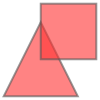

In [3]:
# [Your answer here]
square_coords = np.array([(2,2),(5,5)])
square = Polygon([(2,2),(2,5),(5,5),(5,2)])


triangle_coord = np.array([[0,0],[4,0],[2,4]])
triangle = Polygon(triangle_coord)


MultiPolygon([triangle, square])

> **Ex. 6.1.2** Compute and show the spatial difference of square subtracted triangle, also show the hat is the union of `square` and `triangle`?

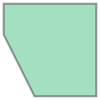

In [4]:
# [Your answer here]
square.difference(triangle)

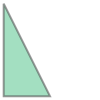

In [5]:
square.intersection(triangle)

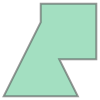

In [6]:
square.union(triangle)

> **Ex. 6.1.3** Make a GeoSeries out of `square`, `triangle`. Plot the geoseries.

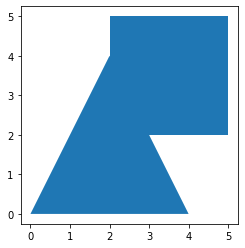

In [7]:
# [Your answer here]
g = gpd.GeoSeries([triangle, square])
g.plot()

### Part 9.2: Working with house sale prices

Data on danish municipalities are available [here](https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson) from Open Knowledge Denmark.

#### Basic operations with Geopandas

> **Ex. 9.2.1** Load the municipalities data using `gpd.read_file()`, 
- What is the CRS of the dataframe - what projection does it correspond to? Turn the CRS into a meter based system.
- Which three munipalities have the largest area?

> Note: to find the entire area of a municipality which consists of multiple shapes (e.g. municipalities covering islands). you can use the `unary_union` method for GeoSeries.

In [8]:
url = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson"

In [9]:
# [Your answer here]
kommuner = gpd.read_file(url)

Use the script below to add regional information for municipalities. This code block assumes that your geodataframe is names `kommuner`.

In [10]:
kommuner.columns = kommuner.columns.str.lower()
    
# information for municipality
kommune_info = pd.read_json('https://dawa.aws.dk/kommuner')\
                .pipe(lambda df: \
                        df.assign(komkode=df.kode.astype(str).str.zfill(4)))\
                .loc[:,['komkode','regionskode']]\
                

region_info = pd.read_json('https://dawa.aws.dk/regioner/')\
                .loc[:,['kode','navn']]\
                .add_prefix('regions')

kommuner = kommuner\
                .merge(kommune_info,how='left')\
                .merge(region_info,how='left')

In [11]:
kommuner.head()

,komkode,komnavn,geometry,regionskode,regionsnavn
0,0766,Hedensted,"POLYGON Z ((9.44919 55.86046 -999.00000, 9.460...",1082,Region Midtjylland
1,0766,Hedensted,"POLYGON Z ((10.06198 55.83301 -999.00000, 10.0...",1082,Region Midtjylland
2,0561,Esbjerg,"POLYGON Z ((8.59656 55.53506 -999.00000, 8.601...",1083,Region Syddanmark
3,0849,Jammerbugt,"POLYGON Z ((9.78314 57.07319 -999.00000, 9.781...",1081,Region Nordjylland
4,0849,Jammerbugt,"POLYGON Z ((9.19738 57.13868 -999.00000, 9.207...",1081,Region Nordjylland


komkode = municipality code

komnavn = municipality name


In [12]:
kommuner.crs

{'init': 'epsg:4326'}

In [13]:
kommuner.to_crs({'init':'epsg:25832'}, inplace=True)

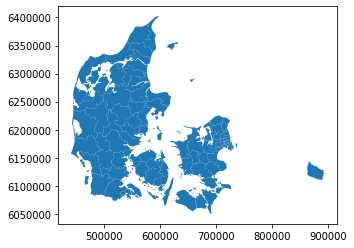

In [14]:
import matplotlib.pyplot as plt
kommuner.plot()

In [15]:
area = kommuner.groupby('komnavn').geometry.apply(lambda d: d.unary_union.area)
area.nlargest(3)

komnavn
Ringkøbing-Skjern    1.494151e+09
Viborg               1.419631e+09
Herning              1.323127e+09
Name: geometry, dtype: float64

> **Ex. 9.2.2** Make two boolean series as follows. 
> - first: row is True if corresponding the row shape is in the Capital Region or Sealand Region (i.e. `'Region Hovedstaden', 'Region Sjælland'`) 
> - second: row is True if the  the row geometry is ***not*** in Bornholm or nearby (i.e. `'Bornholm', 'Christiansø'`)

> Finally make a combined series which takes the value True if both holds, otherwise False and use this series to create a new geodataframe containing only mainland Sealand. 


> *Hint*: recall that we can check if a series elements are elements in a series using the `isin` method


In [16]:
# [Your answer here]
kommuner['capital region'] = kommuner['regionsnavn'].isin(['Region Hovedstaden', 'Region Sjælland'])
kommuner['not bornholm'] = ~kommuner['komnavn'].isin(['Bornholm', 'Christiansø'])

sealand = kommuner[kommuner['capital region'] & kommuner['not bornholm']]
sealand.head()

,komkode,komnavn,geometry,regionskode,regionsnavn,capital region,not bornholm
12,0159,Gladsaxe,"POLYGON Z ((716689.000 6181565.000 -999.000, 7...",1084,Region Hovedstaden,True,True
16,0260,Halsnæs,"POLYGON Z ((685760.650 6206386.190 -999.000, 6...",1084,Region Hovedstaden,True,True
17,0260,Halsnæs,"POLYGON Z ((667293.000 6231338.000 -999.000, 6...",1084,Region Hovedstaden,True,True
18,0187,Vallensbæk,"POLYGON Z ((713579.000 6168252.000 -999.000, 7...",1084,Region Hovedstaden,True,True
19,0187,Vallensbæk,"POLYGON Z ((714395.930 6168389.980 -999.000, 7...",1084,Region Hovedstaden,True,True


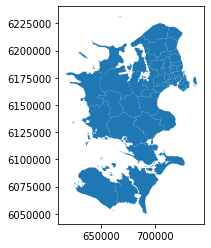

In [17]:
sealand.plot()

> **Ex. 9.2.3** Explain what is the CRS of the GeoDataFrame. How is distance measured using this coordinate system. Extract the extremum values (min,max) in all dimensions of the sealand geodataframe. That is identify the coordinates of the corners in the smallest square covering the entire island.

> *Hint*: extreme values, i.e. bounds, can be found using `.bounds` on a GeoDataFrame (also works on shapes, GeoSeries)

(608082.0108126376, 748531.2771034074, 6037562.350546621, 6243828.930270623)

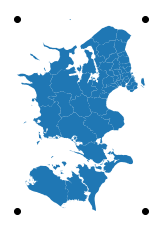

In [18]:
# [Your answer here]
minx, miny, _, _ = sealand.bounds.min(axis = 0)
_,_ , maxx, maxy = sealand.bounds.max(axis = 0)

sealand.plot()
plt.scatter(minx, miny, color='black')
plt.scatter(minx, maxy, color='black')
plt.scatter(maxx, miny, color='black')
plt.scatter(maxx, maxy, color='black')
plt.axis('off')


#### Interpolation of house prices


In the following two exercises we aim to compute local spatial neighborhood measures of house prices in Sealand and around. We do this by making make a grid of Sealand houseprice data and using a neighborregressor to fill in data in squares that dont have any house sales. Thus the exercise will illustrate how to make a interpolation of data which is useful for feature engineering and get a good understanding of the data.

> **Ex. 9.2.4** Construct a 500mx500m grid for Sealand:
>- Make a grid of points 500m apart in horizontal and vertical directions that are within the extremum values of Sealand's shape. Each pair $(e,n)$ in this grid should be the coordinates of the lower left corner in a 500x500 square.
>- For each of these points construct a square polygon assuming that the point is the south west corner of the square. Do this using `cell_coords_to_polygons`.
>- Use `gpd.sjoin` to take the intersection of the municipalities in sealand and the square grid you have constructed. Plot the resulting geodataframe.
>
> *Hint 1:* Once you have created the grid the following function below may be useful for converting into a GeoDataFrame. You need to specify the column names for your x and y coordinates.
>
> *Hint 2:* We can select the points that intersect by using a spatial join between the house locations and municipalities.

In [19]:
dk_crs = {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32}

def cell_coords_to_polygons(square_df, x='e', y='n', dist=500, crs=dk_crs):
    '''
    Convert coordinates to squares in a GeoDataFrame.
       
    Parameters
    ----------
    x : str
        Name of the horizontal coordinate (~longitude)            
    y : str
        Name of the vertical coordinate (~latitude)                        
    dist : int or float
        Size of polygons
    crs : dict
        Coordinate Reference System


    Returns
    ----------
    squares_gdf: geopandas.GeoDataFrame
        This table contains squares as geometry
        and the original data.
    '''
    
    def _to_square_polygon(row):
        '''
        This auxiliary function convert a square's lower,left 
        coordinates to a polygon. 
        
        Parameters
        ----------
        row : pandas.Series
            This is a DataFrame row.            
        
        Returns
        ----------
        poly: shapely.Polygon        
        
        '''
        
        square_coords = ((row[x], row[y]), 
                         (row[x]+dist, row[y]), 
                         (row[x]+dist, row[y]+dist), 
                         (row[x], row[y]+dist))
        
        poly = shapely.geometry.Polygon(square_coords)
        
        return poly
    
    # convert to polygons
    square_geoms = gpd.GeoSeries(square_df.apply(_to_square_polygon, axis=1), crs=crs)
    
    # make GeoDataFrame
    square_gdf = gpd.GeoDataFrame(data=square_df, geometry=square_geoms)
    
    return square_gdf

In [20]:
# [Your answer here]
x = np.arange(start=minx, stop=maxx, step=500) 
y = np.arange(start=miny, stop=maxy, step=500)

square_list =[]
for e in x:
    for n in y:
        square = (e,n)
        square_list.append(square)

square_df = pd.DataFrame(square_list, columns =['e','n'])        
print(square_df.head())        

          e             n
0  617288.0  6.049782e+06
1  617288.0  6.050282e+06
2  617288.0  6.050782e+06
3  617288.0  6.051282e+06
4  617288.0  6.051782e+06


In [21]:
grid = cell_coords_to_polygons(square_df, x='e', y='n', dist=500, crs=dk_crs)

/Users/j./anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:25832'} != {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32})
  "(%s != %s)" % (left_df.crs, right_df.crs)


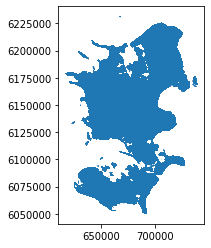

In [22]:
sealand_geo = gpd.sjoin(sealand, grid)
sealand_geo.plot()

> **Ex. 9.2.5**  Load the pre-structured data with house sales prices for Sealand. These data are available on Absalon as a .GeoJSON file. Construct a loop that for each year in the `sale_year` column 
> - extracts the house sales sold in this year, with a square meter price (`price_area`) between between 1000 and 120000. 
> - Selects the four columns `['sale_year', 'e', 'n', 'price_area']` and drops any rows with missing data. 
> - After preparing the data fit a `KNeighborsRegressor` with the coordinate columns `e` and `n` as features and the square-meter price as labels.
> - Computes predictions `preds` where `e`, `n` are taken from the square grid geodataframe you constructed above. Add 250 to each value to predict at the midpoint of the square!
> - creates a new column `p_{year}` in the square-grid geodataframe, containing `np.log10(preds)`
>
> Plot the grid data, coloring the grids by their predicted square meter price in 2012.

In [23]:
from sklearn.neighbors import KNeighborsRegressor
price_gdf = gpd.read_file('houseprices.GeoJSON')
price_gdf.head()

,address,buildYear,salesPeriodTotal,numberOfRooms,paymentCash,residentialArea,areaWeighted,postal,dateRemoved,city,lat,lon,price_area,price_area_log,sale_year,e,n,index_right,mun_name,geometry
0,"Topperne 11, 1. 12",1972,NaN,2,645000.0,49.0,49.0,2620,19-01-2012,Albertslund,55.672423,12.343027,13163.265306,9.485185,2012,710214.000597,6.174689e+06,250,Albertslund,POINT (710214.001 6174689.003)
1,"Topperne 11, 1. 12",1972,NaN,2,575000.0,49.0,49.0,2620,19-07-2012,Albertslund,55.672423,12.343027,11734.693878,9.370305,2012,710214.000597,6.174689e+06,250,Albertslund,POINT (710214.001 6174689.003)
2,Skyttehusene 37,1968,NaN,4,1695000.0,108.0,131.0,2620,12-03-2012,Albertslund,55.672528,12.356639,12938.931298,9.467996,2012,711069.000619,6.174742e+06,250,Albertslund,POINT (711069.001 6174742.003)
3,Rytterhusene 75,1968,NaN,4,1995000.0,108.0,131.0,2620,04-07-2012,Albertslund,55.673089,12.359137,15229.007634,9.630957,2012,711223.000623,6.174812e+06,250,Albertslund,POINT (711223.001 6174812.003)
4,Rytterhusene 75,1968,NaN,4,1795000.0,108.0,131.0,2620,16-08-2012,Albertslund,55.673089,12.359137,13702.290076,9.525318,2012,711223.000623,6.174812e+06,250,Albertslund,POINT (711223.001 6174812.003)


In [24]:
year=2012
year_df = price_gdf[(price_gdf.sale_year==year) & (price_gdf.price_area.between(1000,100000))][['sale_year', 'e', 'n', 'price_area']]
year_df.dropna()
year_df.head()

,sale_year,e,n,price_area
0,2012,710214.000597,6.174689e+06,13163.265306
1,2012,710214.000597,6.174689e+06,11734.693878
2,2012,711069.000619,6.174742e+06,12938.931298
3,2012,711223.000623,6.174812e+06,15229.007634
4,2012,711223.000623,6.174812e+06,13702.290076


In [25]:
X = year_df[['e', 'n']]
X.head()

,e,n
0,710214.000597,6.174689e+06
1,710214.000597,6.174689e+06
2,711069.000619,6.174742e+06
3,711223.000623,6.174812e+06
4,711223.000623,6.174812e+06


Check: 2012
Check: 2013


(611189.4000001774, 745358.5999963677, 6040690.699990359, 6240699.299993621)

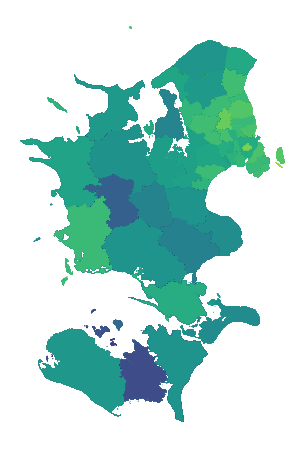

In [34]:
# [Your answer here]
for year in price_gdf['sale_year'].unique():
    print('Check loop: ' +str(year))
    
    # SELECT
    year_df = price_gdf[(price_gdf.sale_year==year) & (price_gdf.price_area.between(1000,100000))][['sale_year', 'e', 'n', 'price_area']]
    year_df.dropna()

    # FIT
    X = year_df[['e', 'n']]
    y = year_df.price_area
    knn =KNeighborsRegressor()
    knn.fit(X,y)
    
    # Predict
    X_grid = sealand_geo[['e','n']]
    X_grid += 250
    preds = knn.predict(X_grid)
    
    sealand_geo['p_'+str(year)] = np.log10(preds)

sealand_geo.plot(figsize=(10,8),column='p_2012') 
plt.axis('off')    

In [27]:
sealand_geo.head()

,komkode,komnavn,geometry,regionskode,regionsnavn,capital region,not bornholm,index_right,e,n,p_2012,p_2013
12,0159,Gladsaxe,"POLYGON Z ((716689.000 6181565.000 -999.000, 7...",1084,Region Hovedstaden,True,True,73437,717788.0,6.186282e+06,4.467540,4.396267
310,0173,Lyngby-Taarbæk,"POLYGON Z ((718173.000 6189190.000 -999.000, 7...",1084,Region Hovedstaden,True,True,73437,717788.0,6.186282e+06,4.467540,4.396267
12,0159,Gladsaxe,"POLYGON Z ((716689.000 6181565.000 -999.000, 7...",1084,Region Hovedstaden,True,True,73801,718288.0,6.186282e+06,4.463336,4.402331
310,0173,Lyngby-Taarbæk,"POLYGON Z ((718173.000 6189190.000 -999.000, 7...",1084,Region Hovedstaden,True,True,73801,718288.0,6.186282e+06,4.463336,4.402331
12,0159,Gladsaxe,"POLYGON Z ((716689.000 6181565.000 -999.000, 7...",1084,Region Hovedstaden,True,True,75612,720788.0,6.181782e+06,4.383920,4.399534


(611189.4000001774, 745358.5999963677, 6040690.699990359, 6240699.299993621)

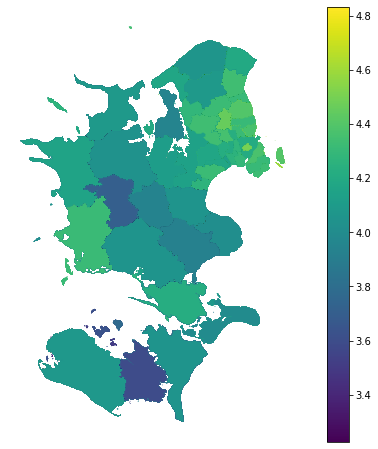

In [28]:
sealand_geo.plot(figsize=(10,8),column='p_2012', legend=True) 
plt.axis('off')